# CTC
## Coulometric titration comparison

This script can be used to compare the coulometric titration curves of one active 
material (AM) in two different systems (can be cells, electrolytes, ...).
The application of CTC to NCM in typical liquid and solid electrolyte 
to obtain the mass of active material ($m_{AM}$) is described in the according publication.
[Link to manuscript (once published)](https://test.com)

This notebook contains two main utilities:
- $m_{AM}$ from two OCV values compared to a GITT like coulometric titration curve
- $m_{AM}$ from two coulometric titration curves
    
To apply this script some things need to be prepared:
- .txt file with the coulometric titration data of the AM (in reference system). (`titration_ref_filename`)
- Coulometric titration data of the AM in system 2. For this:
    - OCV1, $\Delta q$, OCV2 (for 1st utility)
    - .txt file (`titration_sys2_filename`) (for 2nd utility) 
    - optional: .txt file with raw measurement data (`measurement_sys2_filename`) (for visualization) 
  
If you want an error estimation you further need:
from the reference (LIB):
- $\delta m_{AM,ref}$ ($e.g.$, weighing error. Enter as value in the notebook!)
- $\delta U_{\pm,ref}$ ($e.g.$, from incomplete relaxation and/or self discharge. Enter as columns in the .txt file!)
- $\delta Q_{\pm,instr}$ ($e.g.$, from instrument accuracy. Here cumulative. Enter as column in the .txt file!)
- $\delta Q_{-,sd}$ ($e.g.$, from self discharge. Here cumulative. Enter as column in the .txt file!)
- ... (other errors are possible to include. Contact me for suggestions!)

from system 2 (SSB):
- $\delta m_{AM,sys2}$ ($e.g.$, weighing error. Enter as value in the notebook!)
- $\delta U_{\pm,sys2}$ ($e.g.$, from incomplete relaxation and/or self discharge. Enter as columns in the .txt file!)
- $\delta Q_{\pm,instr}$ ($e.g.$, from instrument accuracy. Here cumulative. Enter as column in the .txt file!) 
- ... (other errors are possible to include. Contact me for suggestions!) 

For further specifics of the input data, check the cells that handles file imports.

In [10]:
#-------------------imports----------------------
import os #to open files
import numpy as np #to get access to np.random.uniform(), np.array(), np.float, np.average, np.sqrt
import pandas as pd #to process data in dataframes
import matplotlib.pyplot as plt #for plotting
from scipy.interpolate import interp1d #for interpolation of the titration data

from pathlib import Path #to get the paths to the input and output files right
BASE_DIR = Path.cwd().parent #path to the repository root
DATA_DIR = BASE_DIR / "data"
OUTPUT_DIR = BASE_DIR / "output"
OUTPUT_DIR.mkdir(exist_ok=True) #Create output directory if it does not exist

#-----------------Explanation of repository structure----------------
#- data/        : input files
#- output/      : evaluated data generated by this notebook
#- notebooks/   : location of this notebook
# paths are handled relative to the repository root. as shown above

In [2]:
#--------------------------------------------
#----------------Import parameters---------
#--------------------------------------------

#filename to your reference cell (LIB titration data) (located in /data)
titration_ref_filename = "LIB_titration-data.txt"

#--------------------------------------------
#----------------measurement params----------
#--------------------------------------------

m_AM_ref = 0.00525 #g - mass of reference cell
Q0_ref = 0.11622757 #mAh - initial capacity (this comes from formation cycles)
#error calculation (you dont have to provide these for basic utility)
dm_AM_ref = 0.00009 #g mass error of reference cell, determination explained in manuscript (possible to use weighing error)
dQ0 = 0.011 #mAh error of initial charge, determination explained in manuscript (possible to estimate)

#--------------------------------------------
#----------------Data parameters-------------
#--------------------------------------------

dec_inp = '.' #this is the decimal sign of your input file/s
sep_inp = '\t' #this is the separator of your input file/s
OCV_key = "OCV [V]" #this is your voltage column
cap_key = "Q_corr [mAh]" #this is your capacity column
scap_key = "q [mAh/g]" #this will be created as column during the script
cap_cumulative = True #False #adapt this to your reference file. False for "not cumulative" = "0.1mAh in all rows"
# -------------error calculation--------------
calculate_errors = True #if you set this to True, you need to provide additional data (see above)
dV_pos_key = "dV pos [V]" #positive potential error (all error values are absolute and positive sign)
dV_neg_key = "dV neg [V]" #negative potential error
dQ_shared_sym_key = "Q0_err,instr cumulative shared sym [mAh]" #symmetric charge error from instrument accuracy
dQ_shared_neg_key = "Q_err,sd cumulative shared neg [mAh]" #negative-only charge error (during charge) from self discharge
dq_mass_key = "dq_mass [mAh/g]" #q error that comes from mass (will be created in the script)

#--------------------------------------------
#----------------Export parameters---------
#--------------------------------------------
export_titration_ref_with_errors_filename = "LIB_titration-data_with-error-calculation.txt" #filename
do_Export = True #set this to False if you dont want to export/create files

Opened C:\python projects\CTC-data-analysis\data\LIB_titration-data.txt ...
Exported C:\python projects\CTC-data-analysis\output\LIB_titration-data_with-error-calculation.txt...


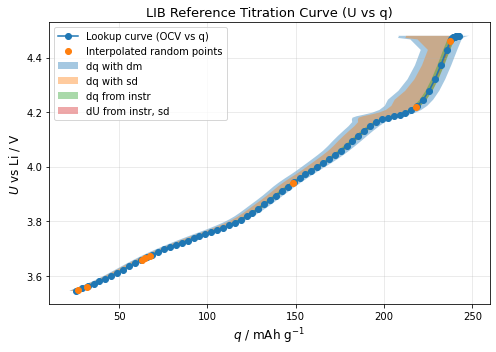

In [3]:
#-----------------------------------open the file------------------------------------
df = pd.read_csv(DATA_DIR / titration_ref_filename, sep=sep_inp, encoding='unicode_escape', skiprows = 0, decimal = dec_inp, dtype=np.float64)
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True) #remove unnamed columns
print("Opened {0} ...".format(DATA_DIR / titration_ref_filename))
#create additional columns in the df
#specific capacity
if not cap_cumulative: #(if the capacity is not cumulative in the ref file then it already sums it here)
    df[cap_key] = df[cap_key].cumsum()
df[scap_key] = df[cap_key]/m_AM_ref #specific capacity column is created
df[dq_mass_key] = df[scap_key] * (dm_AM_ref / m_AM_ref) #create column for the (symmetric) specific mass error
#get all the relevant data columns with variable names (from the user input keys)
q_vals = df[scap_key].values
U_vals = df[OCV_key].values
Q_vals = df[cap_key].values
#errors
U_err_pos = df[dV_pos_key].values
U_err_neg = df[dV_neg_key].values
Q_err_shared_sym = df[dQ_shared_sym_key].values
Q_err_shared_neg = df[dQ_shared_neg_key].values
q_err_mass = df[dq_mass_key].values 

#--------------------------------------routine----------------------------------------
#this part shows the ref-curve and some interpolation tests
#and introduces the calc active materials methods
#-------------------------------------------------------------------------------------

#this interpolates the data and the error curves (to create a smooth titration curves with smooth error bands)
interp_Q = interp1d(U_vals, Q_vals, kind='linear', fill_value="extrapolate")
interp_dU_pos = interp1d(U_vals, U_err_pos, kind='linear', fill_value="extrapolate")
interp_dU_neg = interp1d(U_vals, U_err_neg, kind='linear', fill_value="extrapolate")
interp_dQ_shared_sym = interp1d(U_vals, Q_err_shared_sym, kind='linear', fill_value="extrapolate")
interp_dQ_shared_neg = interp1d(U_vals, Q_err_shared_neg, kind='linear', fill_value="extrapolate")

#export the titration file with speccap and errors with name: export_titration_ref_with_errors_filename
#we want to export some additional columns so the titration curve can be easily displayed as U vs q
#Q-errors from
#everything (incl mass)
df["q_err_pos tot [mAh/g]"] = (Q_err_shared_sym)/m_AM_ref + q_err_mass
df["q_err_neg tot [mAh/g]"] = (Q_err_shared_neg + Q_err_shared_sym )/m_AM_ref + q_err_mass
#self discharge
df["q_err_pos incl sd [mAh/g]"] = (Q_err_shared_sym)/m_AM_ref
df["q_err_neg incl sd [mAh/g]"] = (Q_err_shared_neg + Q_err_shared_sym )/m_AM_ref
# q-errors from instr
df["q_err_pos from instr [mAh/g]"] = (Q_err_shared_sym )/m_AM_ref
df["q_err_neg from instr [mAh/g]"] = (Q_err_shared_sym)/m_AM_ref

if do_Export:
    df.to_csv(OUTPUT_DIR / export_titration_ref_with_errors_filename, sep ='\t')
    print("Exported {0}...".format(OUTPUT_DIR / export_titration_ref_with_errors_filename))

#-----------------------------testing & plotting--------------------------------------
#this tests the interpolation functions and 
#plots the titration curve + error bands
#-------------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(7, 5))

# q-errors from mass-error
ax.fill_betweenx(U_vals, q_vals - (Q_err_shared_neg + Q_err_shared_sym )/m_AM_ref - q_err_mass, q_vals + (Q_err_shared_sym)/m_AM_ref + q_err_mass, alpha=0.4, label="dq with dm")

# q-errors from self discharge
ax.fill_betweenx(U_vals, q_vals - (Q_err_shared_neg + Q_err_shared_sym )/m_AM_ref, q_vals + (Q_err_shared_sym)/m_AM_ref, alpha=0.4, label="dq with sd")

# q-errors from instr
ax.fill_betweenx(U_vals, q_vals - Q_err_shared_sym/m_AM_ref, q_vals + Q_err_shared_sym/m_AM_ref, alpha=0.4, label="dq from instr")

# Potential (U) uncertainty shading
ax.fill_between(q_vals, U_vals - U_err_neg, U_vals + U_err_pos, alpha=0.4, label="dU from instr, sd")

# Main titration curve
ax.plot(q_vals, U_vals, 'o-', label="Lookup curve (OCV vs q)") 

# Test interpolated points
test_voltages = np.random.uniform(df[OCV_key].min(), df[OCV_key].max(), 8)
test_Qs = interp_Q(test_voltages)
test_qs = test_Qs / m_AM_ref
ax.plot(test_qs, test_voltages, 'o', label="Interpolated random points")
# Styling
ax.set_xlabel(r'$\mathit{q}$ / mAh g$^{-1}$', fontsize=12)
ax.set_ylabel(r'$\mathit{U}$ vs Li / V', fontsize=12)
ax.set_title("LIB Reference Titration Curve (U vs q)", fontsize=13)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#---------------------------------Ask functions--------------------------------------
#below are utility functions that get info from the titration curve Get_delta_q_ref()
#and calculate like Calc_m_AM() and Calc_AM_util()
#-------------------------------------------------------------------------------------

#first we need a derivative of the titration curve to understand sensitivity in Q for changes in U
def derivative(f, x, h=1e-6):
    return (f(x+h) - f(x-h)) / (2*h)

def Get_delta_q_ref(V1, V2, V1_err=(0,0), V2_err=(0,0)):
    #---------------- use titration curve---------------
    Q1 = interp_Q(V1)
    Q2 = interp_Q(V2)
    delta_Q = abs(Q2 - Q1)
    delta_q = delta_Q / m_AM_ref
    #-------------------error calculation---------------
    #-------U-errors----------
    #voltage uncertainties both from the look-up values and titration curve
    dV1_pos = V1_err[0] + interp_dU_pos(V1)
    dV1_neg = V1_err[1] + interp_dU_neg(V1)
    dV2_pos = V2_err[0] + interp_dU_pos(V2)
    dV2_neg = V2_err[1] + interp_dU_neg(V2)
    #sensitivities via derivative (delta_Q = Q2 - Q1)
    dQ_dV1 = derivative(interp_Q, V1) 
    dQ_dV2 = derivative(interp_Q, V2)
    A = dQ_dV2
    B = -dQ_dV1    
    #-------Q-errors (shared)----------
    # symmetric (instrument) error cancels partially
    dQ1_shared_pos = interp_dQ_shared_sym(V1)
    dQ2_shared_pos = interp_dQ_shared_sym(V2)
    # negative-only (self-discharge) cancels partially aswell
    dQ1_shared_neg = interp_dQ_shared_neg(V1)
    dQ2_shared_neg = interp_dQ_shared_neg(V2)
    # ---------------- combine all errors ----------------
    dQ_pos = abs(A * dV2_pos) + abs(B * dV1_pos) + dQ2_shared_pos - dQ1_shared_pos
    dQ_neg = abs(A * dV2_neg) + abs(B * dV1_neg) + (dQ2_shared_pos - dQ1_shared_pos) + (dQ2_shared_neg - dQ1_shared_neg)
    #-----mass-------
    dq_pos_stat = dQ_pos / m_AM_ref
    dq_neg_stat = dQ_neg / m_AM_ref
    d_q_mass = delta_q * dm_AM_ref / m_AM_ref

    dq_pos = dq_pos_stat + d_q_mass
    dq_neg = dq_neg_stat + d_q_mass

    #print("delta q = {0} mAh/g +{1}/-{2}".format(round(delta_q,2), round(dq_pos,2), round(dq_neg,2))) #uncomment, if info from the ask function should be printed
    return delta_q, (dq_pos, dq_neg)

def Calc_m_AM(Q_sys2, delta_q_ref, Q_sys2_err=(0,0), delta_q_ref_err = (0,0)):
    m_AM = Q_sys2 / delta_q_ref
    # positive limit from errors
    m_AM_pos = (Q_sys2 + Q_sys2_err[0]) / (delta_q_ref - delta_q_ref_err[1]) - m_AM
    # negative limit from errors
    m_AM_neg = m_AM - (Q_sys2 - Q_sys2_err[1]) / (delta_q_ref + delta_q_ref_err[0])
    return m_AM, (m_AM_pos, m_AM_neg)

def Calc_AM_util(m_sys2_det, m_sys2_tot, m_sys2_err=(0,0), m_sys2_tot_err=0):
    AM_util = 100 * m_sys2_det / m_sys2_tot
    # positive limit from errors
    AM_util_pos = 100 * (m_sys2_det + m_sys2_err[0]) / (m_sys2_tot - m_sys2_tot_err) - AM_util
    # negative limit from errors
    AM_util_neg = AM_util - 100 * (m_sys2_det - m_sys2_err[1]) / (m_sys2_tot + m_sys2_tot_err)
    return AM_util, (AM_util_pos, AM_util_neg)


### First utility - Calculate m_AM based on OCV1, OCV2 and delta Q - Inputs
As user, please enter:
- OCV1 and OCV2 (in [V])
- measured $\Delta Q$ between OCV1 and OCV2 (in [mAh])
- for AM utilization $\Theta_{AM}$, enter total $m_{AM}$ in your measurement cell (in [g])

For error calculation you need:
- $\delta U_{OCV1,OCV2,\pm}$ (in [V]). This could include instrument error and e.g. an estimation of incomplete relaxation.
- $\delta(\Delta Q_{\pm})$ (in [mAh]). This could also include instrument error and e.g. parasitic currents.
- $\delta m$ (in [g]) from weighing the AM during cell preparation.

In [4]:
#--------------Example use(user input here please)---
OCV1 = 3.63  # V
OCV2 = 4.00  # V
Q = 0.6      # mAh
m_weighed = 0.011 #g
#error calculation
OCV1_err = (0.01, 0.03)  # (+, -) V
OCV2_err = (0.01, 0.02) # (+, -) V
Q_err = (0.01, 0.01) # (+, -) mAh
m_weighed_err =  0.001 #g
#----------------------------------------

### Calculate m_AM and create plot

Your cell shows 54.55 mAh/g (weighed mass = 11.0 mg).
-> m_AM is actually 5.56 mg +0.05/-0.05
This corresponds to 50.5 % +10.1/-8.3 CAM utilization


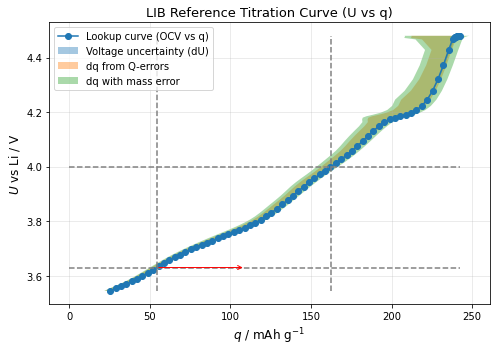

In [5]:
#----------------call the ask functions on the titration curve with the inputs--------
#Below we first call Get_delta_q_ref() and then call Calc_m_AM() and Calc_AM_util()
#The rest is just visualization
#-------------------------------------------------------------------------------------
delta_q_ref, (delta_q_ref_err_pos, delta_q_ref_err_neg) = Get_delta_q_ref(OCV1, OCV2, OCV1_err, OCV2_err) #Get the difference in specific capacity of the LIB between OCV1,OCV2
m_new, (m_err_pos, m_err_neg) = Calc_m_AM(Q, delta_q_ref, (0.01 * Q, 0.02 * Q), (delta_q_ref_err_pos, delta_q_ref_err_pos)) #Calculate active mass in sys 2 based on the user input Q and the LIB value
AM_util, (AM_util_err_pos, AM_util_err_neg) = Calc_AM_util(m_new, m_weighed, (m_err_pos, m_err_neg), m_weighed_err) #Calculate utilization based on the actual active mass and the weiged mass
#print the results
print("Your cell shows {0} mAh/g (weighed mass = {1} mg).".format(round(Q/m_weighed,2),round(1000 * m_weighed,2)))
print("-> m_AM is actually {0} mg +{1}/-{2}".format(round(1000 * m_new,2), round(100 * m_err_pos,2),round(100 * m_err_neg,2)))
print("This corresponds to {0} % +{1}/-{2} CAM utilization".format(round(AM_util,1), round(AM_util_err_pos,1),round(AM_util_err_neg,1)))

#-----------------------------#visualize the results----------------------------------
#We plot again the LIB titration curve and draw horizontal lines at OCV1 and OCV2
#The arrow symbolizes the specific capacity of sys2 with respect to m_weighed
#the missing part to reach the second vertical line is the missing active mass
#-------------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(q_vals, U_vals, 'o-', label="Lookup curve (OCV vs q)") # Main titration curve
# Voltage uncertainty shading
ax.fill_between(q_vals, U_vals - U_err_neg, U_vals + U_err_pos, alpha=0.4, label="Voltage uncertainty (dU)")
# q-errors from Q-errors
ax.fill_betweenx(U_vals, q_vals - (Q_err_shared_neg + Q_err_shared_sym )/m_AM_ref, q_vals + (Q_err_shared_sym)/m_AM_ref, alpha=0.4, label="dq from Q-errors")
# q-errors from mass-error
ax.fill_betweenx(U_vals, q_vals - (Q_err_shared_neg + Q_err_shared_sym )/m_AM_ref - q_err_mass, q_vals + (Q_err_shared_sym)/m_AM_ref + q_err_mass, alpha=0.4, label="dq with mass error")
# draw OCV1 and OCV2 lines
x = [0, df[scap_key].max()] #x-axis min and max for lines
ax.plot(x, [OCV1, OCV1], linestyle='--', color = 'grey') #OCV1
ax.plot(x, [OCV2, OCV2], linestyle='--', color = 'grey') #OCV2
#horizontal line
ax.plot([interp_Q(OCV2)/m_AM_ref, interp_Q(OCV2)/m_AM_ref], [df[OCV_key].min(),df[OCV_key].max()], linestyle='--', color = 'grey') #final q
ax.plot([interp_Q(OCV1)/m_AM_ref, interp_Q(OCV1)/m_AM_ref], [df[OCV_key].min(),df[OCV_key].max()],  linestyle='--', color = 'grey') #final q
#arrow for the charge
arrow_start_q = interp_Q(OCV1)/m_AM_ref
ax.annotate('', xy=(arrow_start_q + Q/m_weighed, OCV1),xytext=(arrow_start_q, OCV1), arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->'))
# Styling
ax.set_xlabel(r'$\mathit{q}$ / mAh g$^{-1}$', fontsize=12)
ax.set_ylabel(r'$\mathit{U}$ vs Li / V', fontsize=12)
ax.set_title("LIB Reference Titration Curve (U vs q)", fontsize=13)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Second utility - Inputs
Minimal input:
- $m_{AM,sys2}$ mass of active material in [g] (`m_sys2`) 
- optional for error calculation (set `do_Error_calculation=True`): $\delta m_{AM,sys2}$ (`m_sys2_err`)
- .txt file with the coulometric titration data of the AM (in sys2). (`titration_sys2_filename`)
    - required columns: OCV1/V, OCV2/V, Q/mAh (`sys2_ocv1_key`,`sys2_ocv2_key`,`sys2_cap_key`)
    - optional columns for error calculation (set `do_Error_calculation=True`):
        - $\delta U_{OCV1,OCV2,\pm}$ 
        - $\delta Q_{\pm}$

If you want to plot the raw measurement of sys2 - set `plot_sys2=True` and provide:
- .txt file with the raw data (in sys2). (`measurement_sys2_filename`)
    - required columns: U/V, Q/mAh (`CTC_sys2_v_key`, `CTC_sys2_cap_key`)
- $Q_0$ in mAh, the initial charge e.g. from formation cycles (`CTC_shift_Q`)

In [8]:
#----------inputs for second utility (plot & evaluate whole CTC measurement)------------
#As stated above you need a .txt file here that contains titration data from system 2 (SSB)
#You also need to enter additional info like mass, mass error and column names from the .txt file
#Additionally one can plot the raw measurement data, see below
#-------------------------------------------------------------------------------------

#-------inputs for titration data of sys2------------------------
titration_sys2_filename = "badSSB_titration-data.txt"
#titration_sys2_filename = "goodSSB_titration-data.txt"

#set this to False if you dont want to include error calculation
do_Error_calculation = True
do_Export_CTC_result = True
export_CTC_result_filename_addon = "_ctc-final-result" # created filename will be "titration_sys2_filename" + "export_CTC_result_filename_addon" + ".txt"

sys2_decimal = '.'
sys2_ocv1_key = 'OCV1 [V]'
sys2_ocv2_key = 'OCV2 [V]'
sys2_cap_key = 'Q [mAh]'
sys2_scap_key = 'q [mAh/g]' #will be created
sys2_dQ_key = 'dQ [mAh]' #will be created

#error calculation
sys2_docv1_pos_key = 'dOCV1 pos [V]'
sys2_docv1_neg_key = 'dOCV1 neg [V]'
sys2_docv2_pos_key = 'dOCV2 pos [V]'
sys2_docv2_neg_key = 'dOCV2 neg [V]'
sys2_dcap_pos_key = 'dQ pos [mAh]'
sys2_dcap_neg_key = 'dQ neg [mAh]'

sys2_dscap_pos_key = 'dq pos [mAh/g]' #will be created
sys2_dscap_neg_key = 'dq neg [mAh/g]' #will be created
sys2_ddQ_pos_key = 'ddQ pos [mAh]' #will be created
sys2_ddQ_neg_key = 'ddQ neg [mAh]' #will be created

m_sys2 = 0.00900 #g # bad SSB
#m_sys2 = 0.01047 #g # good SSB 

m_sys2_err = 0.1/1000 #g #mass error of weighing in sys2 (SSB)

#this needs to be edited if you want to calculate the "selected" average utilization only between the first and second value
l = [1,5] #used_voltage_windows bad SSB
#l = [1,6] #used_voltage_windows good SSB


#this is the x-axis scaling for the final plot
plot_x_range = [40, 120] #this means from 40% utilization to 120%

#-------inputs for CTC complete measurement of sys2------------------------
plot_sys2 = False#True #this allows drawing of the ctc measurement file
measurement_sys2_filename = "badSSB_measurement.txt"
#measurement_sys2_filename = "goodSSB_measurement.txt"
CTC_sys2_decimal = '.'
CTC_sys2_v_key = "U [V]"
CTC_sys2_cap_key = "Q [mAh]"
CTC_sys2_scap_key = 'q [mAh/g]' #will be created
#CTC_shift_Q  is the total charge before the CTC measurement, e.g. during formation
CTC_shift_Q = 0.19888 #mAh #badSSB
#CTC_shift_Q = 0.25224 #mAh #goodSSB

#--------------------replotting of CTC with scaling factor
SSB_specific_utilized_mass_factor = 0.972 #this is the scaling factor used for plotting
plot_SSB_specific_utilized_mass = False#True #if this is True, then the SSB measurement is plotted again, scaled with the actually utilized mass u provide below

Opened C:\python projects\CTC-data-analysis\data\badSSB_titration-data.txt ...
-----------1------------
CAM util = 54.0 +5.0 -3.0%
-----------------------
-----------2------------
CAM util = 68.0 +7.0 -3.0%
-----------------------
-----------3------------
CAM util = 80.0 +6.0 -4.0%
-----------------------
-----------4------------
CAM util = 83.0 +10.0 -5.0%
-----------------------
-----------5------------
CAM util = 75.0 +10.0 -5.0%
-----------------------
-----------6------------
CAM util = 89.0 +18.0 -5.0%
-----------------------
Average of CAM-utilization = 74.7 +- 11.5
-----------------------
Selected Average of CAM-utilization = 76.4 +- 5.8


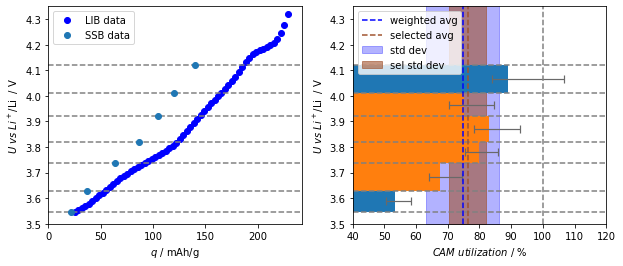

Exported CTC result for:      badSSB_titration-data.txt 
based on titration data referenced to:      LIB_titration-data.txt 
with filename:      badSSB_titration-data_ctc-final-result.txt


In [9]:
#----------inputs for second utility (plot & evaluate whole CTC measurement)------------
#As stated above you need a .txt file here that contains titration data from system 2 (SSB)
#You also need to enter additional info like mass, mass error and column names from the .txt file
#Additionally one can plot the raw measurement data, see below
#-------------------------------------------------------------------------------------

#-----------------------------------------Open files-------------------------------
#---------------------------------open titration data of sys2----------------------
df1 = pd.read_csv(DATA_DIR / titration_sys2_filename, sep='\t', encoding='unicode_escape', skiprows = 0, decimal = sys2_decimal, dtype=np.float64)
print("Opened {0} ...".format(DATA_DIR / titration_sys2_filename))
#preparation of dataframe
df1[sys2_scap_key] = (df1[sys2_cap_key]/m_sys2) #create specific charge column
df1[sys2_dQ_key] = df1[sys2_cap_key].diff() #create dQ column
df1[sys2_dQ_key].iloc[0] = df1[sys2_scap_key].iloc[0] #set the first dQ to the Q0 which is stored in row 0
#preparation of df for error calculation:
if(do_Error_calculation):
    df1[sys2_dscap_pos_key] = (df1[sys2_dcap_pos_key]/m_sys2) #create specific charge column error pos
    df1[sys2_dscap_neg_key] = (df1[sys2_dcap_neg_key]/m_sys2) #create specific charge column error neg
    df1[sys2_ddQ_pos_key] = df1[sys2_dcap_pos_key] + df1[sys2_dcap_neg_key].shift(1) #create error of dQ pos
    df1[sys2_ddQ_neg_key] = df1[sys2_dcap_neg_key] + df1[sys2_dcap_pos_key].shift(1) #create error of dQ neg

#------------------open the raw measurement file-----------------------------
df_meas = None
if plot_sys2:
    df_meas = pd.read_csv(DATA_DIR / measurement_sys2_filename, sep='\t', encoding='unicode_escape', skiprows = 0, decimal = CTC_sys2_decimal, dtype=np.float64)
    print("Opened {0} ...".format(DATA_DIR / measurement_sys2_filename))
    df_meas[CTC_sys2_scap_key] = (df_meas[CTC_sys2_cap_key])/m_sys2 #get specific capacities with the weighed mass
#-----------------------------------------------------------------------------------

#----------------------------------Evaluate and plot comparison of titration curves---------------------------
#----1st plot: Show U-q curves --------------------2nd plot: CAM utilization each potential difference--------
#-------------------------------------------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
x = [0, df[scap_key].max()] #x-axis min and max for lines
#----------------------------------------first the charge curve plot------------------------------
#-----background plot for the real SSB measurement if desired (change params above)
if plot_sys2:
    ax1.plot(df_meas[CTC_sys2_scap_key] + CTC_shift_Q/m_sys2, df_meas[CTC_sys2_v_key], label ="SSB measurement")#incl. shift by Q0
if plot_SSB_specific_utilized_mass: 
    ax1.plot(df_meas[CTC_sys2_cap_key ]/(m_sys2 * SSB_specific_utilized_mass_factor) + CTC_shift_Q/m_sys2, df_meas[CTC_sys2_v_key], label ="SSB scaled with {0}".format(SSB_specific_utilized_mass_factor))   
ax1.plot(df[scap_key], df[OCV_key],'o', label ="LIB data", color = 'blue') #LIB reference curve
#plot a grey line for each ocv step from the SSB
for i in range(len(df1)):
    Vi = df1[sys2_ocv2_key].iloc[i]
    ax1.plot(x, [Vi, Vi], linestyle='--', color = 'grey') #V2
#-----------plot the ctc of SSB cell
ax1.plot(df1[scap_key], df1[sys2_ocv2_key],'o', label ="SSB data")
#----------plot beauty
ax1.set_xlabel(r'$\mathit{q}$ / mAh/g')
ax1.set_ylabel(r'$\mathit{U}$ $\mathit{vs}$ $Li^+$/Li  / V')
ax1.set_xlim(x)
ax1.set_ylim(3.5, 4.35)
ax1.legend()

#--------------------------------------now the CAM utilization plot-----------------------------------------------
#first find the CAM utilization for all steps in the df1
CAM_m_list = []
CAM_m_err_pos_list = []
CAM_m_err_neg_list = []
CAM_util_list = []
CAM_util_err_list = []
for i in range(1,len(df1)):
    print("-----------{0}------------".format(i))
    if(do_Error_calculation):
        #this here calculated delta q of the ref cell for 2 potentials, then calculates the m_AM of sys2, then the AM_utilization
        dq_ref_i, dq_ref_i_errors = Get_delta_q_ref(df1[sys2_ocv1_key].iloc[i], df1[sys2_ocv2_key].iloc[i])#enter here the errors
        m_AM_i, m_AM_i_errors = Calc_m_AM(df1[sys2_dQ_key].iloc[i], dq_ref_i, (df1[sys2_ddQ_pos_key].iloc[i], df1[sys2_ddQ_neg_key].iloc[i]) , dq_ref_i_errors)
        cf, cf_errors = Calc_AM_util(m_AM_i, m_sys2, m_AM_i_errors, m_sys2_err)
        print("CAM util = {0} +{1} -{2}%".format(round(cf,0),round(cf_errors[0],0),round(cf_errors[1],0)))
        CAM_m_list.append(m_AM_i)
        CAM_m_err_pos_list.append(m_AM_i_errors[0])
        CAM_m_err_neg_list.append(m_AM_i_errors[1])
        CAM_util_list.append(cf)
        CAM_util_err_list.append(cf_errors)
    else:
        #this here calculated delta q of the ref cell for 2 potentials, then calculates the m_AM of sys2, then the AM_utilization
        dq_ref_i, dq_ref_i_errors = Get_delta_q_ref(df1[sys2_ocv1_key].iloc[i], df1[sys2_ocv2_key].iloc[i])#enter here the errors
        m_AM_i, m_AM_i_errors = Calc_m_AM(df1[sys2_dQ_key].iloc[i], dq_ref_i, (0, 0) , dq_ref_i_errors)
        cf, cf_errors = Calc_AM_util(m_AM_i, m_sys2, (0,0), 0)
        print("CAM util = {0}%".format(round(cf,0)))
        CAM_m_list.append(m_AM_i)
        CAM_util_list.append(cf) 
    print("-----------------------")
if(do_Error_calculation):
    #prep error bars (matplotlib wants asymmetric errors as: xerr = [lower, upper])
    AM_util_err_pos = np.array([e[0] for e in CAM_util_err_list])
    AM_util_err_neg = np.array([e[1] for e in CAM_util_err_list])
    xerr = np.vstack([AM_util_err_neg, AM_util_err_pos])   # shape (2, N);
    error_style = dict(ecolor='dimgrey', elinewidth=1.2, capsize=4, capthick=1.2) #error bar style
    #now calculate all the bar widths
    y_positions = np.array(df1[sys2_ocv1_key].iloc[1:]) #potentials
    bar_widths = np.array(df1[sys2_ocv2_key].iloc[1:] - df1[sys2_ocv1_key].iloc[1:]) # potential windows = bar width
    ax2.barh(y_positions, CAM_util_list, xerr=xerr, height=bar_widths, align = 'edge', error_kw=error_style)
    ax2.barh(y_positions[l[0]:l[1]], CAM_util_list[l[0]:l[1]], height=bar_widths[l[0]:l[1]], align = 'edge', error_kw=error_style)
else:
    #now calculate all the bar widths
    y_positions = np.array(df1[sys2_ocv1_key].iloc[1:]) #potentials
    bar_widths = np.array(df1[sys2_ocv2_key].iloc[1:] - df1[sys2_ocv1_key].iloc[1:]) # potential windows = bar width
    ax2.barh(y_positions, CAM_util_list, height=bar_widths, align = 'edge')
    ax2.barh(y_positions[l[0]:l[1]], CAM_util_list[l[0]:l[1]], height=bar_widths[l[0]:l[1]], align = 'edge')    
#plot the horizontal lines aswell
ax2.plot(plot_x_range, [df1[sys2_ocv1_key].iloc[0], df1[sys2_ocv1_key].iloc[0]], linestyle='--', color = 'grey') #first OCV plotted separately
for i in range(len(df1)):
    Vi = df1[sys2_ocv2_key].iloc[i]
    ax2.plot(plot_x_range, [Vi, Vi], linestyle='--', color = 'grey') #V2
ax2.plot([100, 100], [3.5,4.5], linestyle='--', color = 'grey') #line at 100%

#-----------------------calculate and draw avg CAM utilization + std dev-----------
avg_CAM_util = 0
CAM_util_array = np.array(CAM_util_list)
avg_CAM_util = np.average(CAM_util_array)
# Calculating the weighted standard deviation
var_CAM_util = np.average((CAM_util_array - avg_CAM_util)**2)
std_CAM_util = np.sqrt(var_CAM_util)
print("Average of CAM-utilization = {0} +- {1}".format(round(avg_CAM_util,1),round(std_CAM_util,1)))
# Plot the average line
ax2.plot([avg_CAM_util, avg_CAM_util], [3.5, 4.5], linestyle='--', color = 'blue', label="weighted avg")
# Plot the standard deviation as a transparent filled area
ax2.fill_betweenx([3.5, 4.5], avg_CAM_util - std_CAM_util, avg_CAM_util + std_CAM_util, color='blue', alpha=0.3, label="std dev")
print("-----------------------")

#--------------------------draw SELECTED avg CAM utilization + std dev------------------------------
#this here uses only selected voltage windows to calculate the average of the utilization
#to change this, you vary the input l in the cell above. start = l[0], end = l[1]
#---------------------------------------------------------------------------------------------------
selected_CAM_util_array = np.array(CAM_util_list[l[0]:l[1]])
# Calculate the average for the selected range
sel_avg_CAM_util = np.average(selected_CAM_util_array)
# Calculate the standard deviation for the selected range
sel_variance = np.average((selected_CAM_util_array - sel_avg_CAM_util)**2)
sel_std_CAM_util = np.sqrt(sel_variance)
print("Selected Average of CAM-utilization = {0} +- {1}".format(round(sel_avg_CAM_util,1),round(sel_std_CAM_util,1)))
# Plot the selected average line
ax2.plot([sel_avg_CAM_util, sel_avg_CAM_util], [3.5, 4.5], linestyle='--', color = 'sienna', label="selected avg")
# Plot the standard deviation as a transparent filled area for the selected range
ax2.fill_betweenx([3.5, 4.5], sel_avg_CAM_util - sel_std_CAM_util, sel_avg_CAM_util + sel_std_CAM_util, color='sienna', alpha=0.6, label="sel std dev")
#----------plot beauty
ax2.set_xlabel(r'$ \mathit{CAM \ utilization}$ / %')
ax2.set_ylabel(r'$ \mathit{U}$ $\mathit{vs}$ $Li^+$/Li  / V')
ax2.set_ylim(3.5, 4.35)
ax2.set_xlim(plot_x_range)
ax2.legend()
#plt.title(filename) #you can use this to display your filename, is sometime helpful if you want to screenshot results ;)
plt.show()


#------------------------------------------Export CTC evaluation--------------------------
# we add the resulting mass and utilization and their error to the dataframe
# and then export it. (Currently the export is not very error-proof, e.g. varying list lengths can cause errors)
#------------------------------------------------------------------------------------------
if do_Export_CTC_result:
    export_ctc_result_filename = titration_sys2_filename[:-4] + export_CTC_result_filename_addon + ".txt"
    CTC_steps = len(df1)
    if(len(CAM_m_list) == CTC_steps-1):
        df1["m_AM [g]"] = [0] + CAM_m_list
    else:
        print("CAM_m_list length is not correct, won't be exported")
    df1["AM_util [%]"] = [0] + CAM_util_list 
    if(do_Error_calculation):
        df1["m_AM_err_pos [g]"] = [0] + CAM_m_err_pos_list
        df1["m_AM_err_neg [g]"] = [0] + CAM_m_err_neg_list
        df1["AM_util_err_pos [%]"] = np.concatenate(([0], AM_util_err_pos)) #these are np arrays so the 0 row has to be added differently
        df1["AM_util_err_neg [%]"] = np.concatenate(([0], AM_util_err_neg))

    df1.to_csv(OUTPUT_DIR / export_ctc_result_filename, sep ='\t')
    print("Exported CTC result for:      {0} \nbased on titration data referenced to:      {1} \nwith filename:      {2}".format(titration_sys2_filename,titration_ref_filename,export_ctc_result_filename))
